<a href="https://www.kaggle.com/code/thomasfreire/lightning-for-lstm?scriptVersionId=142007291" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## The aim of this project is to display how to implement the Lightning modules to build a LSTM model. The data consists of the readings of sensors of turbofans that were operating until failure. The file in the dataset explains how the columns are displayed and how to understand the data. The task of the project is to predict the Remaining Useful Life of the turbofan after some cycles, the training dataset contains the cycles of over 709 turbofans (units) until the RUL approaches zero. However the units in the test dataset stops the counting of remaining cycles before zero in a random distribution. It might be this way for the model to really predict based in the 

In [237]:
!pip install lightning

In [238]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nasa-cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/x.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/train_FD002.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD004.txt
/kaggle/input/nasa-cmaps/CMaps/RUL_FD003.txt
/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD002.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/nasa-cmaps/cmaps/CMaps/readme.txt
/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD003.txt
/kaggle/input/nasa-cmaps/cmaps/CM

In [239]:
import numpy as np
import pandas as pd
from itertools import chain
import os
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import torch.optim as optim
from torch.utils.data import Dataset
from collections import defaultdict

import random

In [240]:
df1 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD001.txt', sep = ' ', header = None).drop(columns=[26,27])
df2 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD002.txt', sep = ' ', header = None).drop(columns=[26,27])
df3 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD003.txt', sep = ' ', header = None).drop(columns=[26,27])
df4 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/train_FD004.txt', sep = ' ', header = None).drop(columns=[26,27])

In [241]:
settings = ['setting_1','setting_2','setting_3']
sensors = ['sensor{}'.format(i+1) for i in range(0,21)]
indexes = ['unit_number','time_cycle']
columns = indexes + settings + sensors

In [242]:
df1.columns = columns
df2.columns = columns
df3.columns = columns
df4.columns = columns

In [243]:
def add_RUL_column(df):
    max_time_cycles = df.groupby(by='unit_number')['time_cycle'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycle']
    merged = merged.drop("max_time_cycle", axis=1)
    return merged

In [244]:
df1 = add_RUL_column(df1)
df2 = add_RUL_column(df2)
df3 = add_RUL_column(df3)
df4 = add_RUL_column(df4)

In [245]:
test1 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD001.txt', header = None, sep = ' ').drop(columns=[26,27])
test2 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD002.txt', header = None, sep = ' ').drop(columns=[26,27])
test3 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD003.txt', header = None, sep = ' ').drop(columns=[26,27])
test4 = pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/test_FD004.txt', header = None, sep = ' ').drop(columns=[26,27])

In [246]:
test1.columns = columns
test2.columns = columns
test3.columns = columns
test4.columns = columns

In [247]:
u1=test1['unit_number'].nunique()
u2=test2['unit_number'].nunique()
u3=test3['unit_number'].nunique()
u4=test4['unit_number'].nunique()

In [248]:
i1 =np.arange(1,u1+1).reshape(-1,1)
i2 =np.arange(1,u2+1).reshape(-1,1)
i3 =np.arange(1,u3+1).reshape(-1,1)
i4 =np.arange(1,u4+1).reshape(-1,1)

In [249]:
r1 =np.array(pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD001.txt', index_col=False,header= None)[0]).reshape(-1,1)
m1 = np.column_stack((i1, r1))
d1 = pd.DataFrame(m1, columns=['idx','rul1'])
rultest1 = d1.groupby('idx')['rul1'].max()

r2 =np.array(pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD002.txt', index_col=False,header= None)[0]).reshape(-1,1)
m2 = np.column_stack((i2, r2))
d2 = pd.DataFrame(m2, columns=['idx','rul2'])
rultest2 = d2.groupby('idx')['rul2'].max()

r3 =np.array(pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD003.txt', index_col=False,header= None)[0]).reshape(-1,1)
m3 = np.column_stack((i3, r3))
d3 = pd.DataFrame(m3, columns=['idx','rul3'])
rultest3 = d3.groupby('idx')['rul3'].max()

r4 =np.array(pd.read_csv('/kaggle/input/nasa-cmaps/cmaps/CMaps/RUL_FD004.txt', index_col=False,header= None)[0]).reshape(-1,1)
m4 = np.column_stack((i4, r4))
d4 = pd.DataFrame(m4, columns=['idx','rul4'])
rultest4 = d4.groupby('idx')['rul4'].max()

In [250]:
def add_RUL_column_test(test,rul):
    test_grouped_by_unit = test.groupby(by='unit_number')
    max_time_cycles = test_grouped_by_unit['time_cycle'].max()
    merged = test.merge(rul.to_frame(name='rul'), left_on='unit_number',right_index=True)
    merged = merged.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] =  (merged['rul']+merged['max_time_cycle'])-merged['time_cycle']
    return merged

In [251]:
df_test1 = add_RUL_column_test(test1,rultest1).drop(['rul','max_time_cycle'],axis=1)
df_test2 = add_RUL_column_test(test2,rultest2).drop(['rul','max_time_cycle'],axis=1)
df_test3 = add_RUL_column_test(test3,rultest3).drop(['rul','max_time_cycle'],axis=1)
df_test4 = add_RUL_column_test(test4,rultest4).drop(['rul','max_time_cycle'],axis=1)

In [252]:
df_train = pd.concat([df1,df2,df3,df4],ignore_index=True)
df_test = pd.concat([df_test1,df_test2,df_test3,df_test4],ignore_index=True)

In [253]:
ustrain1 = df1['unit_number'].max()
ustrain2 = df2['unit_number'].max()
ustrain3 = df3['unit_number'].max()
unit_abs_train = pd.concat([df1['unit_number'],
           df2['unit_number']+ustrain1,
           df3['unit_number']+ustrain1+ustrain2,
           df4['unit_number']+ustrain1+ustrain2+ustrain3
           ],
          ignore_index=True)

In [254]:
unit_abs_train= pd.Series(unit_abs_train, name= 'unit_abs')
unit_abs_train = pd.DataFrame(unit_abs_train, columns = ['unit_abs'])

In [255]:
ustest1 = df_test1['unit_number'].max()
ustest2 = df_test2['unit_number'].max()
ustest3 = df_test3['unit_number'].max()
unit_abs_test = pd.concat([df_test1['unit_number'],
           df_test2['unit_number']+ustest1,
           df_test3['unit_number']+ustest1+ustest2,
           df_test4['unit_number']+ustest1+ustest2+ustest3
           ],
          ignore_index=True)

In [256]:
unit_abs_test= pd.Series(unit_abs_test, name= 'unit_abs')
unit_abs_test = pd.DataFrame(unit_abs_test, columns = ['unit_abs'])

In [257]:
df_train = pd.concat([unit_abs_train,df_train], axis = 1)
df_test = pd.concat([unit_abs_test,df_test], axis = 1)

## End of the load and cleaning of the data

In [258]:
print('Number of unique units (turbofans) in the datasets: training data:', df_train['unit_abs'].nunique(), 'test data:', df_test['unit_abs'].nunique())

Number of unique units (turbofans) in the datasets: training data: 709 test data: 707


## Let's create a combination of the features with the reduction of dimmensionality (PCA). Later we will utilize this components as features to make tests in our model.

In [259]:
from sklearn.decomposition import PCA
x = df_train.iloc[:,2:-1]
#pca applied only on the timestamp, setting and sensor columns, not in the RUL column
pca = PCA()
pca.fit(x)
pca_data = pca.transform(x)

In [260]:
var = pca.explained_variance_ratio_
var[0]

0.904873954964741

In [261]:
cumsum= np.cumsum(var)

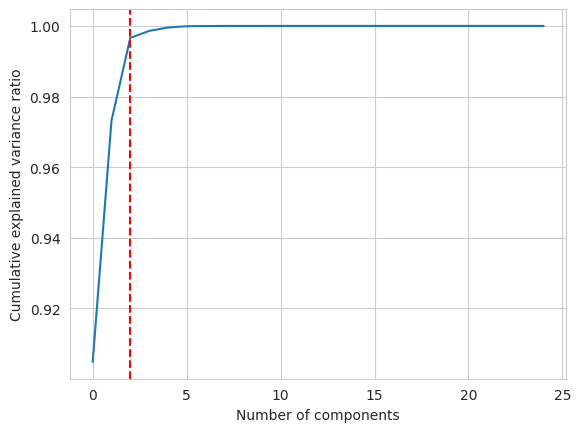

In [262]:
sns.set_style("whitegrid")
plt.plot(cumsum)
plt.axvline(x=2, color='red', linestyle='--')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance ratio')
plt.show()

In [263]:
pca_train = pca_data[:,:5]

In [264]:
x2 = df_test.iloc[:,2:-1]
pca = PCA()
pca.fit(x2)
pca_data2 = pca.transform(x2)
pca_test = pca_data2[:,:5]

## Smoothing
Now let's smooth the data because the as it is stated in the document of the dataset, the readings of the sensors contain noise that might downgrade the LSTM perfomance.

In [265]:
df_train.columns

Index(['unit_abs', 'unit_number', 'time_cycle', 'setting_1', 'setting_2',
       'setting_3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
       'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11',
       'sensor12', 'sensor13', 'sensor14', 'sensor15', 'sensor16', 'sensor17',
       'sensor18', 'sensor19', 'sensor20', 'sensor21', 'RUL'],
      dtype='object')

In [266]:
#Smoothing Train DF
df_train_for_smo = df_train[['unit_abs','setting_1', 'setting_2','setting_3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
                             'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11','sensor12', 'sensor13', 'sensor14',
                             'sensor15', 'sensor16', 'sensor17','sensor18', 'sensor19', 'sensor20', 'sensor21']]
alpha = .2
train_smooth = pd.DataFrame()

for i in range(1, 710):
    unit_data = df_train_for_smo[df_train_for_smo['unit_abs'] == i]  # Extract data for a specific unit
    smoothed_df = unit_data.apply(lambda column: column.ewm(alpha=alpha, adjust=False).mean())
    train_smooth = pd.concat([train_smooth, smoothed_df])

In [267]:
# Smoothing Test DF
df_test_for_smo = df_test[['unit_abs','setting_1', 'setting_2','setting_3', 'sensor1', 'sensor2', 'sensor3', 'sensor4', 'sensor5',
                             'sensor6', 'sensor7', 'sensor8', 'sensor9', 'sensor10', 'sensor11','sensor12', 'sensor13', 'sensor14',
                             'sensor15', 'sensor16', 'sensor17','sensor18', 'sensor19', 'sensor20', 'sensor21']]
test_smooth = pd.DataFrame()

for i in range(1, 710):
    unit_data = df_test_for_smo[df_test_for_smo['unit_abs'] == i]  # Extract data for a specific unit
    smoothed_df = unit_data.apply(lambda column: column.ewm(alpha=alpha, adjust=False).mean())
    test_smooth = pd.concat([test_smooth, smoothed_df])

In [268]:
# Getting back the column time cycle and RUl to be standardize:
train = pd.concat([train_smooth,df_train[['time_cycle','RUL']]],axis=1)
test = pd.concat([test_smooth,df_test[['time_cycle','RUL']]],axis=1)

In [269]:
train.columns

Index(['unit_abs', 'setting_1', 'setting_2', 'setting_3', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
       'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
       'sensor21', 'time_cycle', 'RUL'],
      dtype='object')

In [270]:
scaler = MinMaxScaler(feature_range=(-1, 1))
columns_scaled = ['setting_1', 'setting_2', 'setting_3', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
       'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
       'sensor21', 'time_cycle', 'RUL']

In [271]:
scaled_train_array = scaler.fit_transform(train.drop(['unit_abs'],axis=1))
scaled_test_array = scaler.fit_transform(test.drop(['unit_abs'],axis=1))
df_train_sc = pd.DataFrame(scaled_train_array,columns = columns_scaled)
df_test_sc = pd.DataFrame(scaled_test_array,columns = columns_scaled)

In [272]:
#getting back the unit ID (unit_abs) for the dataframes:
train = pd.concat([df_train['unit_abs'], df_train_sc],axis=1)
test = pd.concat([df_test['unit_abs'], df_test_sc],axis=1)

## Feature Engineering:

In [273]:
train.columns

Index(['unit_abs', 'setting_1', 'setting_2', 'setting_3', 'sensor1', 'sensor2',
       'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7', 'sensor8',
       'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13', 'sensor14',
       'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19', 'sensor20',
       'sensor21', 'time_cycle', 'RUL'],
      dtype='object')

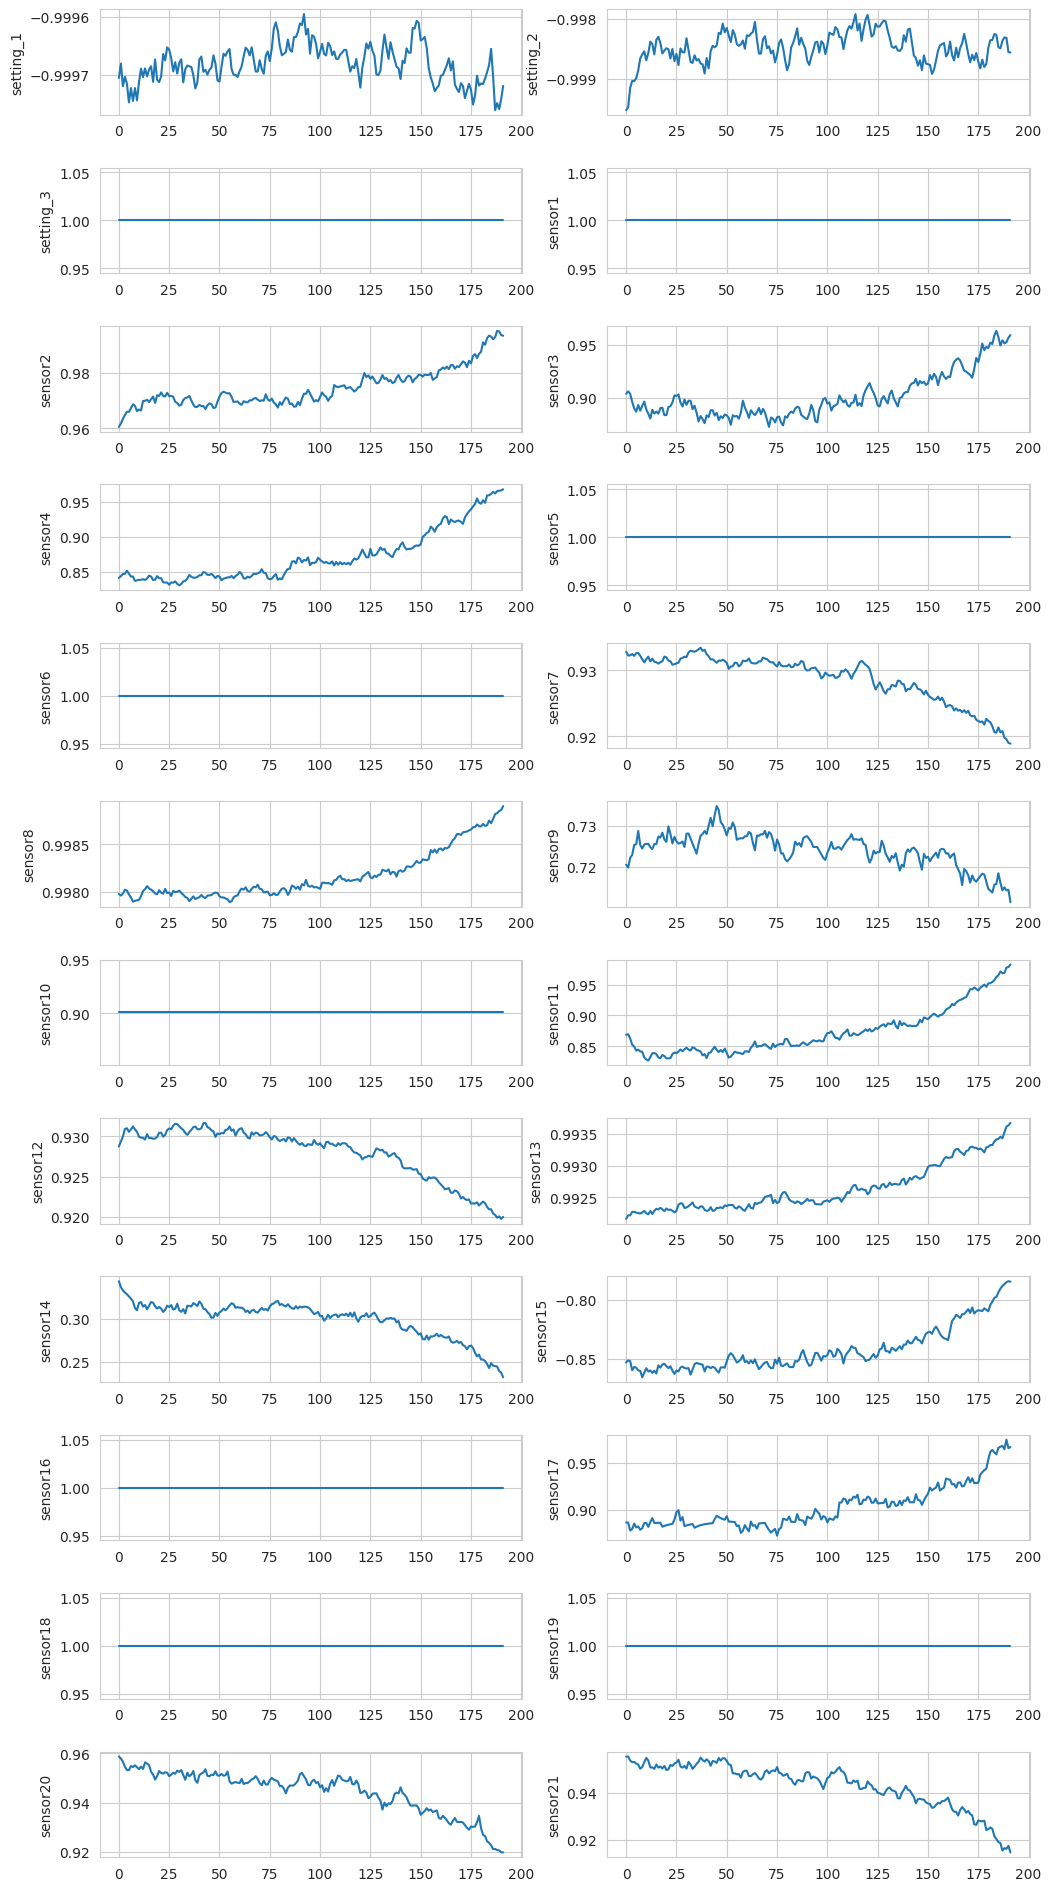

In [274]:
fig, axes = plt.subplots(12, 2, figsize=(12, 24))
plt.subplots_adjust(hspace=0.5)

for i in range(1,25):
    row = (i - 1) // 2
    col = (i - 1) % 2
    sns.lineplot(train[train['unit_abs']==1].iloc[:5000,i], ax=axes[row, col])
plt.show()

In [275]:
cor = train[train['unit_abs']==1].corr()
corl = cor['RUL'].abs().sort_values(ascending=False)
corl

RUL           1.000000
time_cycle    1.000000
sensor13      0.912513
sensor21      0.902345
sensor20      0.899505
sensor7       0.897847
sensor4       0.896811
sensor11      0.894934
sensor12      0.886816
sensor2       0.874611
sensor8       0.874170
sensor17      0.864135
sensor15      0.862653
sensor14      0.859321
sensor3       0.776728
sensor9       0.714364
setting_2     0.194682
setting_1     0.040514
unit_abs           NaN
setting_3          NaN
sensor1            NaN
sensor5            NaN
sensor6            NaN
sensor10           NaN
sensor16           NaN
sensor18           NaN
sensor19           NaN
Name: RUL, dtype: float64

In [276]:
# Utilizing the top 10 sensor reading correlated features:
train_selected = train[['unit_abs','time_cycle','sensor13','sensor21','sensor20','sensor7','sensor4',
                        'sensor11','sensor12','sensor2','sensor8','sensor17','RUL']]

test_selected = test[['unit_abs','time_cycle','sensor13','sensor21','sensor20','sensor7','sensor4',
                        'sensor11','sensor12','sensor2','sensor8','sensor17','RUL']]

In [277]:
#Extract the validation set and predicting sets from the trainning df and test df:
itrain = train_selected[train_selected['unit_abs']<610]
ival = train_selected[train_selected['unit_abs']>609].reset_index(drop=True)
itest = test_selected
ipred  = test_selected[test_selected['unit_abs']>607].reset_index(drop=True)

In [278]:
print('Units for each set:',
      'Train:' ,itrain['unit_abs'].nunique(), 
      ', Validation:', ival['unit_abs'].nunique(), 
      ', Test:', itest['unit_abs'].nunique(),
      ', Prediction:', ipred['unit_abs'].nunique()
     )

Units for each set: Train: 609 , Validation: 100 , Test: 707 , Prediction: 100


In [279]:
# Create sequences for the dataset:
def create_sequences(data: pd.DataFrame,target,seq_len):
    sequences = []
    data_size = len(data)

    for i in tqdm(range(data_size-seq_len+1)):
        sequence = data.iloc[i:i+seq_len,:-1]
        label_position = (i+seq_len-1)
        label = data.iloc[label_position][target]

        sequences.append([sequence,label])
    return sequences

In [280]:
seq_len =10
train_sequences = np.array(create_sequences(itrain,'RUL',seq_len))
val_sequences = np.array(create_sequences(ival, 'RUL', seq_len ))
test_sequences = np.array(create_sequences(itest,'RUL',seq_len))
pred_sequences = np.array(create_sequences(ipred,'RUL',seq_len))

  0%|          | 0/135607 [00:00<?, ?it/s]

  0%|          | 0/24734 [00:00<?, ?it/s]

  0%|          | 0/104888 [00:00<?, ?it/s]

  0%|          | 0/15603 [00:00<?, ?it/s]

# Let's get to the model building:

In [282]:
class TurbofanDataset(Dataset):

    def __init__(self,sequences):
        self.sequences = sequences
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self,idx):
        sequence, label = self.sequences[idx]
        sequence = sequence.drop('unit_abs',axis=1)
        return dict(
          sequence=torch.Tensor(sequence.to_numpy()).float(),
          label = torch.tensor(label).float()
      )

In [283]:
class TurbofanDataModule(L.LightningDataModule):

    def __init__(self, train_sequences,val_sequences,test_sequences,pred_sequences,batch_size=64):
        super().__init__()
        self.train_sequences = train_sequences
        self.val_sequences = val_sequences
        self.test_sequences = test_sequences
        self.pred_sequences = pred_sequences
        self.batch_size = batch_size
        
        seed = 42
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    def setup(self, stage=None):
        self.train_dataset = TurbofanDataset(self.train_sequences)
        self.val_dataset = TurbofanDataset(self.val_sequences)
        self.test_dataset = TurbofanDataset(self.test_sequences)
        self.pred_dataset = TurbofanDataset(self.pred_sequences)

    def train_dataloader(self):
        return DataLoader(
            dataset = self.train_dataset,
            batch_size = self.batch_size,
            shuffle= True,
            num_workers=1
        )
    
    def val_dataloader(self):
        return DataLoader(
            dataset = self.val_dataset,
            batch_size= len(self.val_sequences)//4,
            shuffle = True,
            num_workers=1
        )

    def test_dataloader(self):
        return DataLoader(
            dataset = self.test_dataset,
            batch_size= len(self.test_sequences)//4,
            shuffle = False,
            num_workers=1
        )
    
    def predict_dataloader(self):
        return DataLoader(
            dataset = self.pred_dataset,
            batch_size= len(self.pred_sequences)//4,
            shuffle = False,
            num_workers=1
        )

In [284]:
class RULPredModel(nn.Module):

    def __init__(self, n_features=11, n_hidden=148,n_layers=1,dropout = 0.3):
        super(RULPredModel, self).__init__()
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = dropout
            
        )
        
        self.other_layers = nn.Sequential(
            nn.Linear(in_features=self.n_hidden, out_features=12),
            nn.ReLU(),
            nn.Linear(in_features=12, out_features=1),
        )
        
    def forward(self,x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)
        lstm_out = hidden[-1]
        out = self.other_layers(lstm_out)

        return out

In [285]:
class RULLightning(L.LightningModule):

    def __init__(self, model=RULPredModel(), lr=0.004):
        super(RULLightning,self).__init__()
        self.lr = lr
        self.model = model
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences)
        loss = self.criterion(outputs, 
                              labels.unsqueeze(dim=1)
                              )
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences)
        loss = self.criterion(outputs, 
                              labels.unsqueeze(dim=1)
                             )
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label']
        outputs = self(sequences)
        loss = self.criterion(outputs,
                              labels.unsqueeze(dim=1)
                             )
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def predict_step(self, 
                     batch, 
                     batch_idx, 
                    ):
        sequences = batch['sequence']
        y_hat = self(sequences)
        return y_hat

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        return optimizer

In [286]:
logger_v1 = TensorBoardLogger(save_dir="/kaggle/working/", name="logs_v1")
callback_v1 = [ModelCheckpoint(save_top_k=1,
                             verbose=True,
                             monitor='val_loss',
                             save_last = True,
                             mode='min',
                             filename='best_model',
                             dirpath = logger_v1.log_dir
                              ),
               EarlyStopping(monitor='val_loss',
                             patience=3,
                             mode='min',
                            )
              ]

In [287]:
dm_v1 = TurbofanDataModule(train_sequences,
                        val_sequences,
                        test_sequences,
                        pred_sequences
                        )

In [288]:
RULPred1 = RULPredModel()

In [289]:
model_v1 = RULLightning(RULPred1)

In [296]:
trainer_v1 = L.Trainer(max_epochs=20,
                    callbacks = callback_v1,
                    devices = 1,
                    log_every_n_steps=1,
                    logger=logger_v1,
                     )
trainer_v1.fit(model_v1, datamodule= dm_v1)

INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type         | Params
-------------------------------------------
0 | model     | RULPredModel | 97.1 K
1 | criterion | MSELoss      | 0     
-------------------------------------------
97.1 K    Trainable params
0         Non-trainable params
97.1 K    Total params
0.388     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 2119: 'val_loss' reached 0.04469 (best 0.04469), saving model to '/kaggle/working/logs_v1/version_4/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 1, global step 4238: 'val_loss' reached 0.04337 (best 0.04337), saving model to '/kaggle/working/logs_v1/version_4/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 2, global step 6357: 'val_loss' reached 0.04319 (best 0.04319), saving model to '/kaggle/working/logs_v1/version_4/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 3, global step 8476: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 4, global step 10595: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 5, global step 12714: 'val_loss' was not in top 1


In [299]:
cp_v1 = "/kaggle/working/logs_v1/version_4/best_model.ckpt"

In [300]:
test_v1 = trainer_v1.test(datamodule=dm_v1, ckpt_path=cp_v1)

INFO: Restoring states from the checkpoint path at /kaggle/working/logs_v1/version_4/best_model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/logs_v1/version_4/best_model.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.052170492708683014    │
└───────────────────────────┴───────────────────────────┘

In [301]:
predicted_v1 = trainer_v1.predict(datamodule=dm_v1, ckpt_path=cp_v1)

INFO: Restoring states from the checkpoint path at /kaggle/working/logs_v1/version_4/best_model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/logs_v1/version_4/best_model.ckpt


Predicting: 0it [00:00, ?it/s]

In [302]:
def get_pred(df:list):
    pred_np = df[0].numpy().reshape(1,-1).reshape(-1)
    for i in range(1,5):
        values = df[i].numpy().reshape(1,-1).reshape(-1)
        pred_np = np.append(pred_np,values)
    pred_series = pd.Series(pred_np, name='RUL')
    return pred_series

In [303]:
pred_v1 = get_pred(predicted_v1)

In [304]:
true_y = pd.Series(pred_sequences[:,1])
df_true_y = pd.concat([ipred[9:]['unit_abs'].reset_index(drop=True),true_y.rename('RUL')],axis=1)

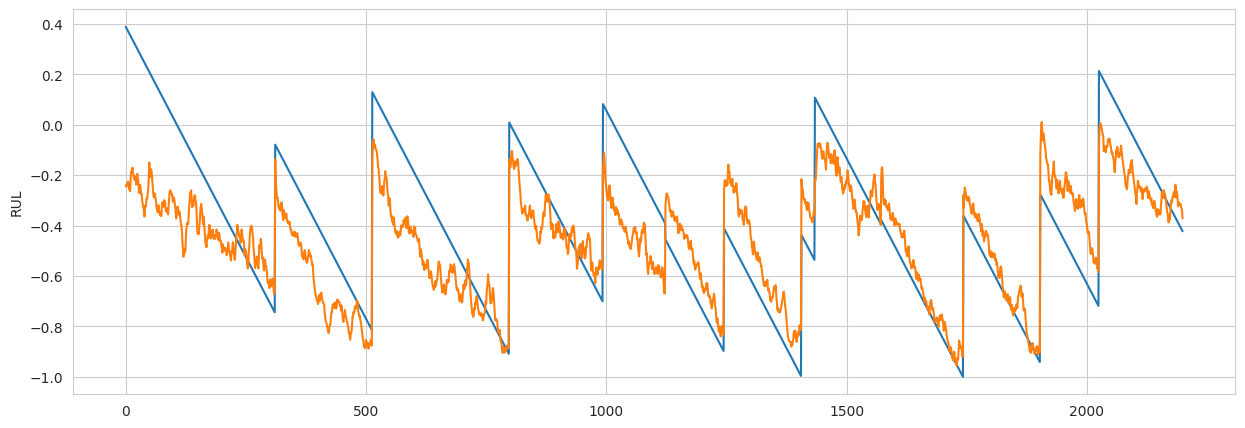

In [305]:
plt.figure(figsize=(15,5))
sns.lineplot(true_y[:2200])
sns.lineplot(pred_v1[:2200])
plt.show()

## Change some parameters to make the LSTM more deep:

In [306]:
logger_v2 = TensorBoardLogger(save_dir="/kaggle/working/", name="logs_v2")
callback_v2 = [ModelCheckpoint(save_top_k=1,
                             verbose=True,
                             monitor='val_loss',
                             save_last = True,
                             mode='min',
                             filename='best_model',
                             dirpath = logger_v2.log_dir
                              ),
               EarlyStopping(monitor='val_loss',
                             patience=3,
                             mode='min',
                            )
              ]

In [307]:
rulpred2 = RULPredModel(n_features=11,n_hidden=70,n_layers=3,dropout=0.6)

In [308]:
model_v2 = RULLightning(rulpred2)

In [309]:
trainer_v2 = L.Trainer(max_epochs=20,
                    callbacks = callback_v2,
                    devices = 1,
                    log_every_n_steps=1,
                    logger=logger_v2,
                     )
trainer_v2.fit(model_v2, datamodule= dm_v1)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type         | Params
-------------------------------------------
0 | model     | RULPredModel | 103 K 
1 | criterion | MSELoss      | 0     
-------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.414     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 2119: 'val_loss' reached 0.04977 (best 0.04977), saving model to '/kaggle/working/logs_v2/version_1/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 1, global step 4238: 'val_loss' reached 0.04545 (best 0.04545), saving model to '/kaggle/working/logs_v2/version_1/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 2, global step 6357: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 3, global step 8476: 'val_loss' reached 0.04516 (best 0.04516), saving model to '/kaggle/working/logs_v2/version_1/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 4, global step 10595: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 5, global step 12714: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 6, global step 14833: 'val_loss' reached 0.04474 (best 0.04474), saving model to '/kaggle/working/logs_v2/version_1/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 7, global step 16952: 'val_loss' reached 0.04165 (best 0.04165), saving model to '/kaggle/working/logs_v2/version_1/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 8, global step 19071: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 9, global step 21190: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 10, global step 23309: 'val_loss' was not in top 1


In [312]:
cp_v2 = "/kaggle/working/logs_v2/version_1/best_model.ckpt"

In [313]:
test_v2 = trainer_v2.test(datamodule=dm_v1, ckpt_path=cp_v2)

INFO: Restoring states from the checkpoint path at /kaggle/working/logs_v2/version_1/best_model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/logs_v2/version_1/best_model.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.057031046599149704    │
└───────────────────────────┴───────────────────────────┘

In [314]:
predicted_v2 = trainer_v2.predict(datamodule=dm_v1, ckpt_path=cp_v2)

INFO: Restoring states from the checkpoint path at /kaggle/working/logs_v2/version_1/best_model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/logs_v2/version_1/best_model.ckpt


Predicting: 0it [00:00, ?it/s]

In [315]:
pred_v2 = get_pred(predicted_v2)

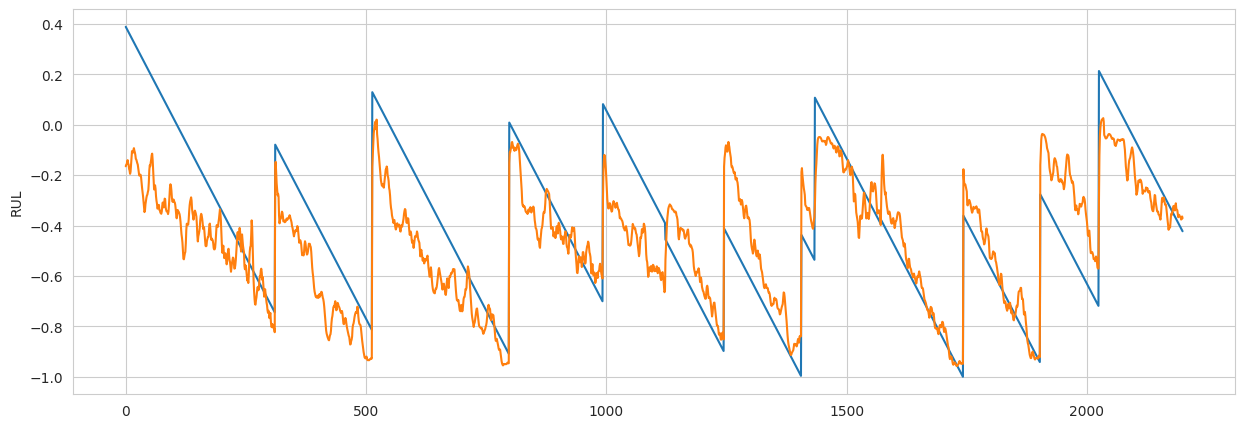

In [316]:
plt.figure(figsize=(15,5))
sns.lineplot(true_y[:2200])
sns.lineplot(pred_v2[:2200])
plt.show()

## The change of structure in the LSTM model worse the performance. Let's use now the PCA components as the features and see if it helps to approach a better result.

In [317]:
pca_train = pd.DataFrame(pca_train, columns = ['Component1','Component2','Component3','Component4','Component5'])
pca_test = pd.DataFrame(pca_test, columns = ['Component1','Component2','Component3','Component4','Component5'])
df_train_v3 = pd.concat([pca_train,train_selected[['unit_abs','time_cycle','RUL']]],axis=1)
df_test_v3 = pd.concat([pca_test,test_selected[['unit_abs','time_cycle','RUL']]],axis=1)

In [319]:
iiitrain = df_train_v3[df_train_v3['unit_abs']<610]
iiival = df_train_v3[df_train_v3['unit_abs']>609].reset_index(drop=True)
iiitest = df_test_v3
iiipred  = df_test_v3[df_test_v3['unit_abs']>607].reset_index(drop=True)

In [320]:
seq_len =10
train_sequences_v3 = np.array(create_sequences(iiitrain,'RUL',seq_len))
val_sequences_v3 = np.array(create_sequences(iiival, 'RUL', seq_len ))
test_sequences_v3 = np.array(create_sequences(iiitest,'RUL',seq_len))
pred_sequences_v3 = np.array(create_sequences(iiipred,'RUL',seq_len))

  0%|          | 0/135607 [00:00<?, ?it/s]

  0%|          | 0/24734 [00:00<?, ?it/s]

  0%|          | 0/104888 [00:00<?, ?it/s]

  0%|          | 0/15603 [00:00<?, ?it/s]

In [321]:
dm_v3 = TurbofanDataModule(train_sequences_v3,
                        val_sequences_v3,
                        test_sequences_v3,
                        pred_sequences_v3
                        )

In [322]:
RULpred3 = RULPredModel(n_features=6)

In [323]:
model_v3 = RULLightning(model=RULpred3)

In [324]:
logger_v3 = TensorBoardLogger(save_dir="/kaggle/working/", name="logs_v3")
callback_v3 = [ModelCheckpoint(save_top_k=1,verbose=True,monitor='val_loss',save_last = True,mode='min',filename='best_model',
                             dirpath = logger_v3.log_dir,
                            ),
             EarlyStopping(monitor='val_loss',
                           patience=3,
                           mode='min',
                          )
              ]

In [325]:
trainer_v3 = L.Trainer(max_epochs=20,
                    callbacks = callback_v3,
                    devices = 1,
                    log_every_n_steps=1,
                    logger=logger_v3,
                     )
trainer_v3.fit(model_v3, datamodule= dm_v3)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name      | Type         | Params
-------------------------------------------
0 | model     | RULPredModel | 94.2 K
1 | criterion | MSELoss      | 0     
-------------------------------------------
94.2 K    Trainable params
0         Non-trainable params
94.2 K    Total params
0.377     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Epoch 0, global step 2119: 'val_loss' reached 0.07140 (best 0.07140), saving model to '/kaggle/working/logs_v3/version_3/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 1, global step 4238: 'val_loss' reached 0.06304 (best 0.06304), saving model to '/kaggle/working/logs_v3/version_3/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 2, global step 6357: 'val_loss' reached 0.06200 (best 0.06200), saving model to '/kaggle/working/logs_v3/version_3/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 3, global step 8476: 'val_loss' reached 0.05973 (best 0.05973), saving model to '/kaggle/working/logs_v3/version_3/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 4, global step 10595: 'val_loss' reached 0.05866 (best 0.05866), saving model to '/kaggle/working/logs_v3/version_3/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 5, global step 12714: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 6, global step 14833: 'val_loss' reached 0.05735 (best 0.05735), saving model to '/kaggle/working/logs_v3/version_3/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 7, global step 16952: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 8, global step 19071: 'val_loss' reached 0.05705 (best 0.05705), saving model to '/kaggle/working/logs_v3/version_3/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 9, global step 21190: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 10, global step 23309: 'val_loss' was not in top 1


In [330]:
cp_v3 = "/kaggle/working/logs_v3/version_3/best_model.ckpt"

In [327]:
test_trainer_v3 = trainer_v3.test(datamodule=dm_v3, ckpt_path=cp_v3)

INFO: Restoring states from the checkpoint path at /kaggle/working/logs_v3/version_3/best_model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/logs_v3/version_3/best_model.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.09074431657791138    │
└───────────────────────────┴───────────────────────────┘

In [328]:
predicted_v3 = trainer_v3.predict(datamodule=dm_v3, ckpt_path=cp_v3)

INFO: Restoring states from the checkpoint path at /kaggle/working/logs_v3/version_3/best_model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: Loaded model weights from the checkpoint at /kaggle/working/logs_v3/version_3/best_model.ckpt


Predicting: 0it [00:00, ?it/s]

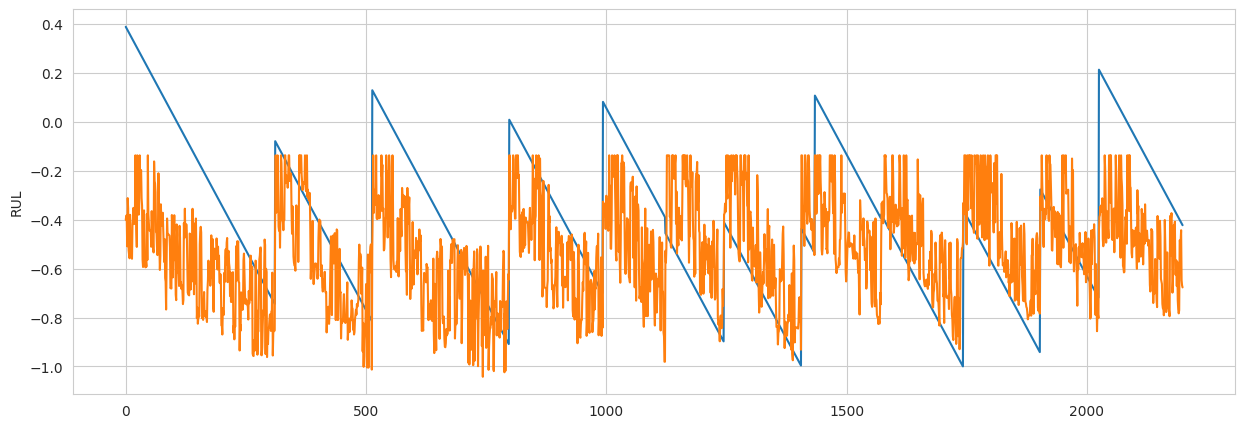

In [329]:
pred_v3 = get_pred(predicted_v3)
plt.figure(figsize=(15,5))
sns.lineplot(true_y[:2200])
sns.lineplot(pred_v3[:2200])
plt.show()

### As we can see the first model is the best to suit the task. Utilizing the components of PCA perform poorly to somehow limited the range of the fitting, maybe the activation function should be replaced for one that be suitable for the PCA scale.

### With the plot of the predicted values, we could see how the model understands the patterns and how the parameter influence the fitting of the LSTM. The model has way too space for improvement but the aim of this project is to implement the modules of Lightning and to display how the tool makes the building much sound and cleaner. 

### Later I will compare the performance with a Tree-base model (LightGBM), that is much simpler and faster and may surprise how good the model can perform comparing to LSTM.